<a href="https://colab.research.google.com/github/mdsiam135/thesis_2025/blob/main/Extra_Trees_Classifier(3_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# ================================
# Improved Machine Learning Classification Pipeline
# ================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report, log_loss)
from sklearn.model_selection import validation_curve
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

# ================================
# Configuration
# ================================
TARGET_COL = 'Production (M.Ton)'


In [20]:

# ================================
# Step 1: Load and validate datasets
# ================================
try:
    train_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/train.csv')
    val_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/validation.csv')
    test_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/test.csv')

    print(f"✅ Datasets loaded successfully")
    print(f"Train shape: {train_df.shape}")
    print(f"Validation shape: {val_df.shape}")
    print(f"Test shape: {test_df.shape}")

except FileNotFoundError as e:
    print(f"❌ Error loading datasets: {e}")
    train_df, val_df, test_df = None, None, None

✅ Datasets loaded successfully
Train shape: (3942, 84)
Validation shape: (845, 84)
Test shape: (845, 84)


In [21]:
# ================================
# Step 2: Create quantile-based labels
# ================================
def create_labels(df, q_list=None, target_col=TARGET_COL):
    """Create quantile-based labels with validation"""
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in dataset")

    if q_list is None:
        quantiles = df[target_col].quantile([0.33, 0.66]).values
        print(f"Quantile thresholds: {quantiles}")
    else:
        quantiles = q_list

    def label_func(x):
        if pd.isna(x):
            return 'unknown'  # Handle missing values
        elif x <= quantiles[0]:
            return 'low'
        elif x <= quantiles[1]:
            return 'medium'
        else:
            return 'high'

    labels = df[target_col].apply(label_func)
    return labels, quantiles

# Create labels
train_labels, q_list = create_labels(train_df)
val_labels, _ = create_labels(val_df, q_list)
test_labels, _ = create_labels(test_df, q_list)

train_df['Prod_Label'] = train_labels
val_df['Prod_Label'] = val_labels
test_df['Prod_Label'] = test_labels

# Check label distribution
print("\nLabel Distribution:")
for dataset_name, labels in [('Train', train_labels), ('Val', val_labels), ('Test', test_labels)]:
    print(f"{dataset_name}: {labels.value_counts().to_dict()}")

Quantile thresholds: [1071.5565 3900.1916]

Label Distribution:
Train: {'high': 1340, 'medium': 1301, 'low': 1301}
Val: {'medium': 290, 'low': 278, 'high': 277}
Test: {'high': 302, 'low': 274, 'medium': 269}


In [22]:
# ================================
# Step 3: Prepare features and scale
# ================================
exclude_cols = [TARGET_COL, 'Prod_Label']
features = [col for col in train_df.columns if col not in exclude_cols]
print(f"\nUsing {len(features)} features for training")

X_train = train_df[features]
y_train = train_df['Prod_Label']
X_val = val_df[features]
y_val = val_df['Prod_Label']
X_test = test_df[features]
y_test = test_df['Prod_Label']

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


Using 83 features for training


In [23]:

# ================================
# Step 4: Train Extra Trees Classifier
# ================================
model = ExtraTreesClassifier(
    n_estimators=150,
    max_depth=25,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

print("Training Extra Trees Classifier...")
model.fit(X_train_scaled, y_train)
print("✅ Training completed")

Training Extra Trees Classifier...
✅ Training completed


Generating training progress plots (this may take a moment)...
  Progress: 20/100 epochs completed
  Progress: 40/100 epochs completed
  Progress: 60/100 epochs completed
  Progress: 80/100 epochs completed
  Progress: 100/100 epochs completed


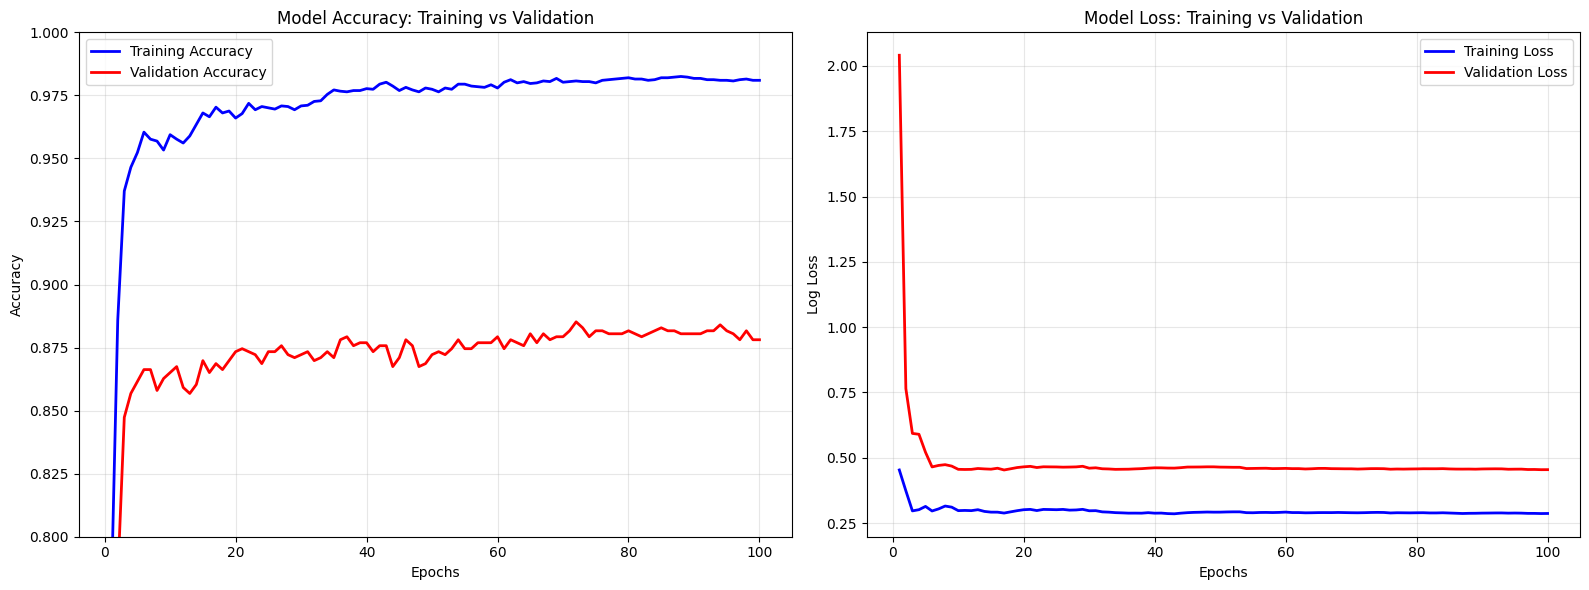


Final Training Accuracy: 0.9810
Final Validation Accuracy: 0.8781
Final Training Loss: 0.2870
Final Validation Loss: 0.4547

Generating learning curve summary...


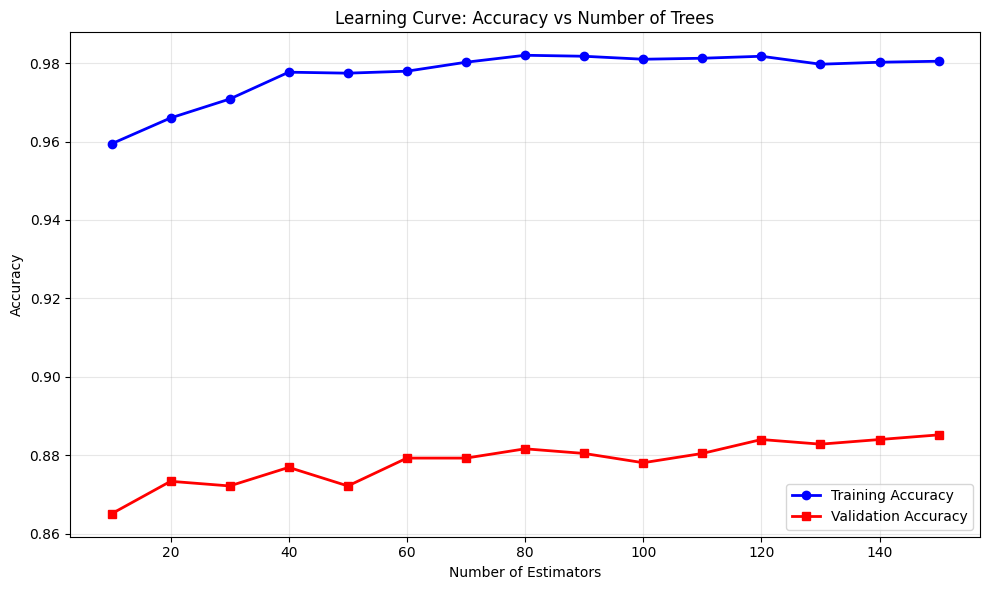

In [24]:
# ================================
# Step 5: Training Progress Simulation (Accuracy & Loss Plots)
# ================================
def plot_training_progress():
    """Plot training progress with accuracy and loss over epochs (n_estimators)"""
    epochs = np.arange(1, 101)  # 1 to 100 estimators
    train_acc = []
    val_acc = []
    train_loss = []
    val_loss = []

    print("Generating training progress plots (this may take a moment)...")

    for epoch in epochs:
        # Train model with current number of estimators
        temp_model = ExtraTreesClassifier(
            n_estimators=epoch,
            max_depth=25,
            random_state=42,
            class_weight='balanced',
            n_jobs=-1
        )
        temp_model.fit(X_train_scaled, y_train)

        # Get predictions
        train_pred = temp_model.predict(X_train_scaled)
        val_pred = temp_model.predict(X_val_scaled)

        # Calculate accuracies
        train_acc.append(accuracy_score(y_train, train_pred))
        val_acc.append(accuracy_score(y_val, val_pred))

        # Calculate losses (log loss)
        train_proba = temp_model.predict_proba(X_train_scaled)
        val_proba = temp_model.predict_proba(X_val_scaled)
        train_loss.append(log_loss(y_train, train_proba, labels=temp_model.classes_))
        val_loss.append(log_loss(y_val, val_proba, labels=temp_model.classes_))

        # Progress indicator
        if epoch % 20 == 0:
            print(f"  Progress: {epoch}/100 epochs completed")

    # Create the plots
    plt.figure(figsize=(16, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label='Training Accuracy', color='blue', linewidth=2)
    plt.plot(epochs, val_acc, label='Validation Accuracy', color='red', linewidth=2)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Model Accuracy: Training vs Validation")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0.8, 1.0)  # Focus on the relevant range

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Training Loss', color='blue', linewidth=2)
    plt.plot(epochs, val_loss, label='Validation Loss', color='red', linewidth=2)
    plt.xlabel("Epochs")
    plt.ylabel("Log Loss")
    plt.title("Model Loss: Training vs Validation")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print final metrics
    print(f"\nFinal Training Accuracy: {train_acc[-1]:.4f}")
    print(f"Final Validation Accuracy: {val_acc[-1]:.4f}")
    print(f"Final Training Loss: {train_loss[-1]:.4f}")
    print(f"Final Validation Loss: {val_loss[-1]:.4f}")

    return train_acc, val_acc, train_loss, val_loss

# Generate the training progress plots
train_accuracies, val_accuracies, train_losses, val_losses = plot_training_progress()

# ================================
# Step 5b: Efficient learning curve analysis (alternative view)
# ================================
def plot_learning_curve_summary():
    """Plot learning curve summary by varying n_estimators (fewer points)"""
    n_estimators_range = np.arange(10, 151, 10)

    train_scores = []
    val_scores = []

    print("\nGenerating learning curve summary...")
    for n_est in n_estimators_range:
        temp_model = ExtraTreesClassifier(
            n_estimators=n_est,
            max_depth=25,
            random_state=42,
            class_weight='balanced',
            n_jobs=-1
        )
        temp_model.fit(X_train_scaled, y_train)

        train_pred = temp_model.predict(X_train_scaled)
        val_pred = temp_model.predict(X_val_scaled)

        train_scores.append(accuracy_score(y_train, train_pred))
        val_scores.append(accuracy_score(y_val, val_pred))

    plt.figure(figsize=(10, 6))
    plt.plot(n_estimators_range, train_scores, 'b-', label='Training Accuracy', marker='o', linewidth=2)
    plt.plot(n_estimators_range, val_scores, 'r-', label='Validation Accuracy', marker='s', linewidth=2)
    plt.xlabel('Number of Estimators')
    plt.ylabel('Accuracy')
    plt.title('Learning Curve: Accuracy vs Number of Trees')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_learning_curve_summary()

In [25]:

# ================================
# Step 6: Comprehensive evaluation
# ================================
def get_metrics(y_true, y_pred, name):
    """Calculate and display comprehensive metrics"""
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1w = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    f1m = f1_score(y_true, y_pred, average='macro', zero_division=0)

    print(f"\n{name} Metrics:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision (Weighted): {prec:.4f}")
    print(f"Recall (Weighted): {rec:.4f}")
    print(f"F1 Score (Weighted): {f1w:.4f}")
    print(f"F1 Score (Macro): {f1m:.4f}")

    return {
        'Dataset': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1_Weighted': f1w,
        'F1_Macro': f1m
    }

# Get predictions and metrics
train_pred = model.predict(X_train_scaled)
val_pred = model.predict(X_val_scaled)
test_pred = model.predict(X_test_scaled)

metrics_train = get_metrics(y_train, train_pred, "Training")
metrics_val = get_metrics(y_val, val_pred, "Validation")
metrics_test = get_metrics(y_test, test_pred, "Testing")


Training Metrics:
Accuracy: 0.9805
Precision (Weighted): 0.9812
Recall (Weighted): 0.9805
F1 Score (Weighted): 0.9806
F1 Score (Macro): 0.9806

Validation Metrics:
Accuracy: 0.8852
Precision (Weighted): 0.8877
Recall (Weighted): 0.8852
F1 Score (Weighted): 0.8860
F1 Score (Macro): 0.8867

Testing Metrics:
Accuracy: 0.9101
Precision (Weighted): 0.9119
Recall (Weighted): 0.9101
F1 Score (Weighted): 0.9106
F1 Score (Macro): 0.9098


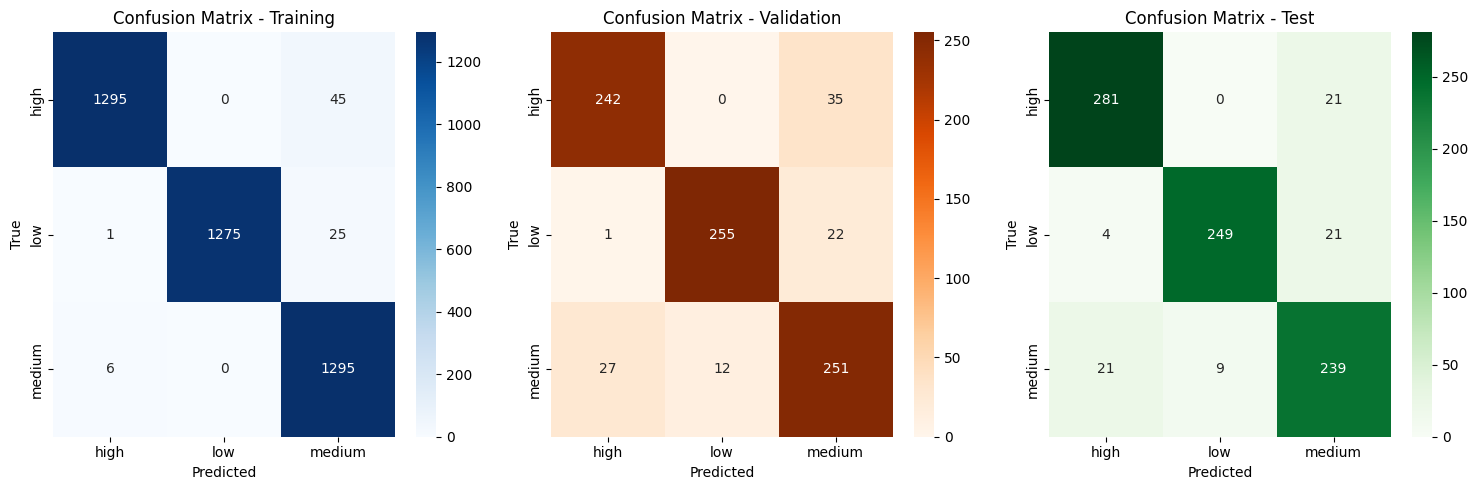

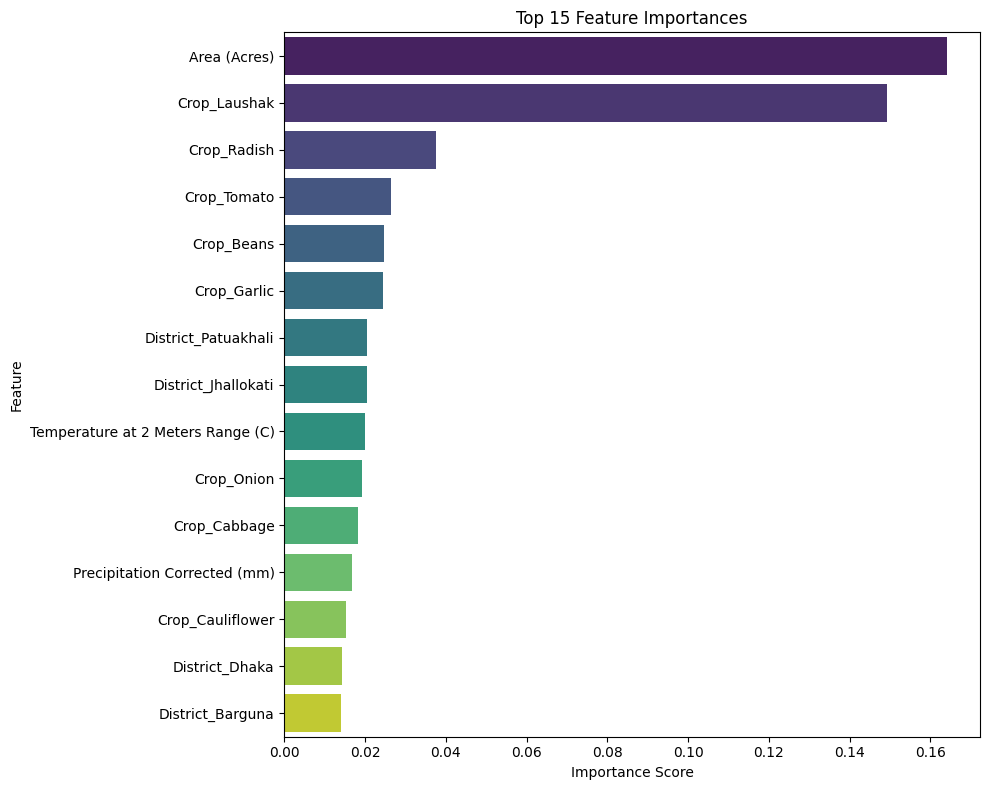

In [26]:
# ================================
# Step 7: Visualizations
# ================================
# Confusion matrices
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
cm_train = confusion_matrix(y_train, train_pred, labels=model.classes_)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Confusion Matrix - Training")
plt.ylabel("True")
plt.xlabel("Predicted")

plt.subplot(1, 3, 2)
cm_val = confusion_matrix(y_val, val_pred, labels=model.classes_)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Oranges',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Confusion Matrix - Validation")
plt.ylabel("True")
plt.xlabel("Predicted")

plt.subplot(1, 3, 3)
cm_test = confusion_matrix(y_test, test_pred, labels=model.classes_)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Confusion Matrix - Test")
plt.ylabel("True")
plt.xlabel("Predicted")

plt.tight_layout()
plt.show()

# Feature importance
importances = model.feature_importances_
feat_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 8))
top_features = feat_df.head(15)
sns.barplot(data=top_features, x='Importance', y='Feature', palette='viridis')
plt.title("Top 15 Feature Importances")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


In [27]:

# ================================
# Step 8: Summary and reports
# ================================
print("\n" + "="*50)
print("CLASSIFICATION REPORTS")
print("="*50)

print("\nValidation Classification Report:")
print(classification_report(y_val, val_pred))

print("\nTest Classification Report:")
print(classification_report(y_test, test_pred))

# Summary table
summary_df = pd.DataFrame([metrics_train, metrics_val, metrics_test])
print("\n" + "="*50)
print("SUMMARY METRICS")
print("="*50)
print(summary_df.round(4).to_string(index=False))

# Model insights
print("\n" + "="*50)
print("MODEL INSIGHTS")
print("="*50)
print(f"• Total features used: {len(features)}")
print(f"• Most important feature: {feat_df.iloc[0]['Feature']} ({feat_df.iloc[0]['Importance']:.4f})")
print(f"• Class distribution: {dict(y_train.value_counts())}")
print(f"• Best performing metric: Test Accuracy = {metrics_test['Accuracy']:.4f}")

# Check for overfitting
train_acc = metrics_train['Accuracy']
test_acc = metrics_test['Accuracy']
overfit_indicator = train_acc - test_acc

if overfit_indicator > 0.1:
    print(f"⚠️  Potential overfitting detected (Train-Test gap: {overfit_indicator:.4f})")
else:
    print(f"✅ Good generalization (Train-Test gap: {overfit_indicator:.4f})")

print(f"\n🎉 Model evaluation completed successfully!")
print(f"📊 Final Test Accuracy: {test_acc:.4f}")
print(f"📊 Validation Macro F1 Score: {metrics_val['F1_Macro']:.4f}")
print(f"📊 Test Macro F1 Score: {metrics_test['F1_Macro']:.4f}")


CLASSIFICATION REPORTS

Validation Classification Report:
              precision    recall  f1-score   support

        high       0.90      0.87      0.88       277
         low       0.96      0.92      0.94       278
      medium       0.81      0.87      0.84       290

    accuracy                           0.89       845
   macro avg       0.89      0.89      0.89       845
weighted avg       0.89      0.89      0.89       845


Test Classification Report:
              precision    recall  f1-score   support

        high       0.92      0.93      0.92       302
         low       0.97      0.91      0.94       274
      medium       0.85      0.89      0.87       269

    accuracy                           0.91       845
   macro avg       0.91      0.91      0.91       845
weighted avg       0.91      0.91      0.91       845


SUMMARY METRICS
   Dataset  Accuracy  Precision  Recall  F1_Weighted  F1_Macro
  Training    0.9805     0.9812  0.9805       0.9806    0.9806
Validat